Extracted: /content/Liver_Medical _Image_Datasets
Dataset root found at: /content/Liver_Medical _Image_Datasets/Liver_Medical_Image _Datasets
Folders inside dataset root: ['Liver_Medical_Image _Datasets']
Using device: cuda
Found 400 image-mask pairs
Train: 360, Val: 40


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Model params: 31043521

Epoch 1/20


Train Loss: 0.5119 | Val Loss: 0.4513 | Val mIoU: 0.7764 | Val mPA: 0.9818
Saved best model

Epoch 2/20


Train Loss: 0.4113 | Val Loss: 0.4022 | Val mIoU: 0.8640 | Val mPA: 0.9887
Saved best model

Epoch 3/20


Train Loss: 0.3847 | Val Loss: 0.3769 | Val mIoU: 0.8733 | Val mPA: 0.9896
Saved best model

Epoch 4/20


Train Loss: 0.3596 | Val Loss: 0.3569 | Val mIoU: 0.9090 | Val mPA: 0.9924
Saved best model

Epoch 5/20


Train Loss: 0.3394 | Val Loss: 0.3333 | Val mIoU: 0.9289 | Val mPA: 0.9940
Saved best model

Epoch 6/20


Train Loss: 0.3165 | Val Loss: 0.3117 | Val mIoU: 0.9172 | Val mPA: 0.9934

Epoch 7/20


Train Loss: 0.2973 | Val Loss: 0.2956 | Val mIoU: 0.9111 | Val mPA: 0.9934

Epoch 8/20


Train Loss: 0.2787 | Val Loss: 0.2735 | Val mIoU: 0.9443 | Val mPA: 0.9956
Saved best model

Epoch 9/20


Train Loss: 0.2611 | Val Loss: 0.2567 | Val mIoU: 0.9422 | Val mPA: 0.9953

Epoch 10/20


Train Loss: 0.2444 | Val Loss: 0.2422 | Val mIoU: 0.9495 | Val mPA: 0.9960
Saved best model

Epoch 11/20


Train Loss: 0.2284 | Val Loss: 0.2235 | Val mIoU: 0.9449 | Val mPA: 0.9955

Epoch 12/20


Train Loss: 0.2182 | Val Loss: 0.2656 | Val mIoU: 0.7587 | Val mPA: 0.9854

Epoch 13/20


Train Loss: 0.2074 | Val Loss: 0.2237 | Val mIoU: 0.8699 | Val mPA: 0.9893

Epoch 14/20


Train Loss: 0.1892 | Val Loss: 0.1864 | Val mIoU: 0.9560 | Val mPA: 0.9965
Saved best model

Epoch 15/20


Train Loss: 0.1746 | Val Loss: 0.1697 | Val mIoU: 0.9619 | Val mPA: 0.9970
Saved best model

Epoch 16/20


Train Loss: 0.1618 | Val Loss: 0.1659 | Val mIoU: 0.9622 | Val mPA: 0.9971
Saved best model

Epoch 17/20


Train Loss: 0.1506 | Val Loss: 0.1504 | Val mIoU: 0.9636 | Val mPA: 0.9972
Saved best model

Epoch 18/20


Train Loss: 0.1396 | Val Loss: 0.1384 | Val mIoU: 0.9619 | Val mPA: 0.9971

Epoch 19/20


Train Loss: 0.1300 | Val Loss: 0.1301 | Val mIoU: 0.9632 | Val mPA: 0.9971

Epoch 20/20


Train Loss: 0.1221 | Val Loss: 0.1204 | Val mIoU: 0.9575 | Val mPA: 0.9967

Final evaluation on validation set:


Final Val Loss: 0.1204 | Val mIoU: 0.9575 | Val mPA: 0.9967
Saved example predictions to ./output/preds
All done.


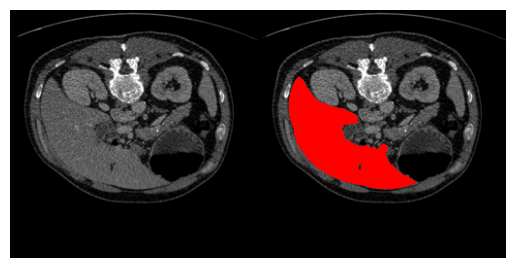

In [1]:
"""
Liver Medical Image Semantic Segmentation - End-to-end PyTorch pipeline

File: liver_unet_pipeline.py
Run: python liver_unet_pipeline.py --data_root ./Liver_Medical_Image_ Datasets --epochs 20

This script performs:
 - dataset loading and preprocessing
 - train/val split
 - U-Net model definition
 - training loop with loss tracking and checkpoint saving
 - evaluation with mIoU and mPA
 - single-image inference and saving example segmentations

Dependencies:
 - python 3.8+
 - torch, torchvision
 - pillow (PIL)
 - numpy
 - matplotlib
 - tqdm

Hyperparameters can be adjusted via argparse CLI flags.

"""

import zipfile, os

# removes accidental space in filename and path
zip_path = "/content/Liver_Medical_Image _Datasets.zip"
extract_dir = "/content/Liver_Medical _Image_Datasets"

# unzips if needed
if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("Extracted:", extract_dir)
else:
    print("Already extracted:", extract_dir)

# auto-detects the actual folder containing Images and Labels
possible_root = None
for root, dirs, files in os.walk(extract_dir):
    if "Images" in dirs and "Labels" in dirs:
        possible_root = root
        break

if possible_root is None:
    raise FileNotFoundError("Could not find 'Images' and 'Labels' folders inside extracted dataset.")
else:
    print("Dataset root found at:", possible_root)

# use that automatically found root as data_root later
data_root = possible_root

# a quick check
print("Folders inside dataset root:", os.listdir(extract_dir))

import os
import argparse
from glob import glob
from PIL import Image
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

# ----------------------------- utility functions -----------------------------
# sets deterministic seeds for random number generators used in the project
def set_seed(seed=42):
    # Python built-in random
    random.seed(seed)
    # NumPy RNG
    np.random.seed(seed)
    #PyTorch CPU RNGs
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# this creates a directory if it doesn't exist
def ensure_dir(path):
    os.makedirs(path, exist_ok=True)


# ----------------------------- dataset --------------------------------------

class LiverSegDataset(Dataset):
    """simple dataset loader expecting two folders: Images/ and Labels/.
    Images (the raw liver CT images) are read as RGB (or grayscale) and resized to target_size.
    Labels (binary masks) are single-channel masks where liver pixels are >0 (white = liver, black = background).
    """

    def __init__(self, image_paths, mask_paths, target_size=(256, 256), augment=False):
        # this ensures that number of images and masks match
        assert len(image_paths) == len(mask_paths), "Images and masks length mismatch"
        self.image_paths = image_paths
        self.mask_paths = mask_paths

        # resize all samples for uniform input size
        self.target_size = target_size

        # if true, apply random horizontal or vertical flips for data augmentation
        self.augment = augment

    def __len__(self):
        # returns the total number of samples in the dataset
        return len(self.image_paths)

    # loads and preprocesses one pair (image, mask)
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx]).convert('L')

        # resize image and mask to target size
        img = img.resize(self.target_size, Image.BILINEAR)
        mask = mask.resize(self.target_size, Image.NEAREST)

        # convert to tensors
        img = TF.to_tensor(img)  # [C,H,W], float in [0,1]
        mask = TF.to_tensor(mask)  # [1,H,W]

        # convert mask to binary (1 for liver, 0 for background)
        mask = (mask > 0.5).float()

        # optionally applies random flips for data augmentation
        if self.augment:
            img, mask = self._random_flip(img, mask)

        # normalize image using ImageNet stats
        img = TF.normalize(img, mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])

        return img, mask

    # this randomly flips the image and mask
    # augmentation helps the model generalize better to unseen orientations
    def _random_flip(self, img, mask):
        if random.random() > 0.5:
            img = TF.hflip(img)
            mask = TF.hflip(mask)
        if random.random() > 0.5:
            img = TF.vflip(img)
            mask = TF.vflip(mask)
        return img, mask


# ----------------------------- model: U-Net ---------------------------------
# popular CNN architecture for image segmentation
# it follows an encoder-decoder structure with skip connections to preserve spatial details

# a helper block used throughout the U-Net, two convolutional layers
# each followed by Batch Normalization and ReLu activation.
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(

            # the first convolution block
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),

            # the second convolution block
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # forward pass through the two layers
        return self.net(x)

# this is the implementation of the U-Net architecture for semantic segmentation
# it includes the encoder, bottleneck and decoder
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64,128,256,512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        # encoder
        # here each step halves the spatial resolution while increasing feature depth
        for f in features:
            self.downs.append(DoubleConv(in_channels, f))
            in_channels = f

        # pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # bottleneck
        # the deepest part of the network connects encoder and decoder
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # decoder
        # each step doubles the spatial resolution and reduces feature depth
        rev_features = features[::-1]
        for f in rev_features:

            # the "ConvTranspose2d" performs upscaling
            self.ups.append(nn.ConvTranspose2d(f*2, f, kernel_size=2, stride=2))

            # after connecting skip connections, apply DoubleConv again
            self.ups.append(DoubleConv(f*2, f))

        # final 1x1 convolution to map features to segmentation output (e.g., liver mask)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    # here we forward pass through the U-Net architecture
    def forward(self, x):
        skip_connections = []
        # the encoder path
        for down in self.downs:
            x = down(x)
            skip_connections.append(x) # saves feature maps for skip connections
            x = self.pool(x)

        # the bottleneck
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1] # reverse for decoder traversal

        # the decoder path
        for idx in range(0, len(self.ups), 2):
            up_transpose = self.ups[idx] # the umpsampling layer
            conv = self.ups[idx+1] # the convolution layer after connecting
            x = up_transpose(x)
            skip = skip_connections[idx//2]

            # handle size mismatch due to uneven input dimensions
            if x.shape != skip.shape:
                skip = self._center_crop(skip, x.shape[2], x.shape[3])

            # connect skip connection (from encoder) with upsampled output
            x = torch.cat((skip, x), dim=1)
            x = conv(x)

        # the final output
        # maps the last feature map to a single output channel (mask)
        x = self.final_conv(x)
        return x

    # center-crop the input tensor to match the target dimensions
    # this ensures connecting works even if spatial sizes differ by 1 pixel
    def _center_crop(self, layer, target_h, target_w):
        _,_,h,w = layer.shape
        start_h = (h - target_h)//2
        start_w = (w - target_w)//2
        return layer[:,:,start_h:start_h+target_h, start_w:start_w+target_w]


# ----------------------------- loss & metrics --------------------------------
# this section defines the loss function used for training and
# the metrics used for model evaluation

# Dice Loss is commonly used for image segmentation tasks.
# it measures the overlap between predicted masks and ground-truth masks.
# a perfect overlap yields a Dice coefficient of 1.0 (loss = 0).
class DiceLoss(nn.Module):

    # smooth is a small constant added to avoid division by zero
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth


    # preds are raw model outputs (logits), shape [N, 1, H, W]
    # targets are binary ground-truth masks, shape [N, 1, H, W]
    def forward(self, preds, targets):
        # applies sigmoid to convert logits -> probabilities in [0, 1]
        preds = torch.sigmoid(preds)
        # flattens predictions and targets to 1D per batch element
        preds = preds.view(preds.size(0), -1)
        targets = targets.view(targets.size(0), -1)
        # compute intersection and union
        intersection = (preds * targets).sum(dim=1)
        # Dice coefficient formula: (2 * intersection) / (sum of areas)
        dice = (2. * intersection + self.smooth) / (preds.sum(dim=1) + targets.sum(dim=1) + self.smooth)
        # dice loss = 1 - Dice coefficient (want to maximize overlap)
        return 1 - dice.mean()

# this computes the segmentation performance metrics, which are:
# Mean Intersection over Union (mIoU) and
# Mean Pixel Accuracy (mPA)
# preds: model predictions (logits)
# targets: ground-truth binary-masks
# threshold: value above which pixels are considered foreground
def compute_metrics(preds, targets, threshold=0.5, eps=1e-6):

    # applies sigmoid to convert logits -> probabilities
    preds = torch.sigmoid(preds)

    # binarizes predictions using threshold (e.g., 0.5)
    preds_bin = (preds > threshold).float()
    targets = targets.float()

    # flattens both tensors for vectorized computation
    preds_flat = preds_bin.view(preds_bin.size(0), -1)
    targets_flat = targets.view(targets.size(0), -1)

    # Intersection over Union (IoU)
    intersection = (preds_flat * targets_flat).sum(dim=1)
    union = (preds_flat + targets_flat - preds_flat*targets_flat).sum(dim=1)
    iou = (intersection + eps) / (union + eps)

    # Pixel Accuracy (PA)
    # counts correctly classified pixels and divides by total pixels
    correct = (preds_flat == targets_flat).sum(dim=1)
    total = preds_flat.size(1)
    pa = correct.float() / float(total)

    # returns the average IoU and PA over the batch
    return iou.mean().item(), pa.mean().item()


# ----------------------------- training & evaluation -------------------------
# this section defines the two key functions:
# - train_one_epoch(): handles one full training pass over the dataset
# - eval_one_epoch(): evaluates model performance on the validation set
# both functions return metrics used for progress tracking and performance monitoring

# runs one full training epoch over the dataset
# model: the neural network (U-Net)
# loader: DataLoader providing batches of training data
# optimizer: optimization algorithm (e.g., Adam)
# criterion: loss function (e.g, DiceLoss)
# device: "cuda" or "cpu"
# returns: average loss over the entire training set for this epoch
def train_one_epoch(model, loader, optimizer, criterion, device):

    model.train() # put model into training mode (enables dropout, batchnorm updates)
    running_loss = 0.0

    # iterate over all training batches
    for imgs, masks in tqdm(loader, desc='Train', leave=False):

        # move images and masks to GPU (if available)
        imgs = imgs.to(device)
        masks = masks.to(device)

        # forward pass: generate predictions
        preds = model(imgs)

        # compute loss between predicted and true masks
        loss = criterion(preds, masks)

        # backpropagation: clear gradients, compute new ones and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # compute average loss across all batches
        running_loss += loss.item() * imgs.size(0)
    return running_loss / len(loader.dataset)

# this tells PyTorch to not track gradients (less memory use)
@torch.no_grad()
# evaluates model performance on the validation dataset.
# this function disables gradient computation,
# computes average validation loss and
# calculates mean IoU and mPA across all validation images
# returns the tuple: (average_loss, mean_IoU, mean_Pixel_Accuracy)
def eval_one_epoch(model, loader, criterion, device):
    model.eval() # switch to evaluation mode (disables dropout, uses running stats)
    running_loss = 0.0
    iou_scores = []
    pa_scores = []

    # iterates over validation batches
    for imgs, masks in tqdm(loader, desc='Eval', leave=False):
        imgs = imgs.to(device)
        masks = masks.to(device)

        # forward pass only (no backpropagation)
        preds = model(imgs)

        # computes validation loss
        loss = criterion(preds, masks)
        running_loss += loss.item() * imgs.size(0)

        # computes IoU and Pixel Accuracy metrics for this batch
        iou, pa = compute_metrics(preds.detach().cpu(), masks.detach().cpu())
        iou_scores.append(iou)
        pa_scores.append(pa)

    # average metrics across all validation batches
    mean_iou = float(np.mean(iou_scores)) if iou_scores else 0.0
    mean_pa = float(np.mean(pa_scores)) if pa_scores else 0.0

    # returns the validation loss, mean IoU and mPA
    return running_loss / len(loader.dataset), mean_iou, mean_pa


# ----------------------------- inference helpers -----------------------------
# this function runs inference on a single image using the trained model.
# it performs preprocessing, model prediction, postprocessing and saves.
# the visualized segmentation result (overlayed on the original image).

@torch.no_grad() # disables gradient calculation for faster inference
# this performs inference on a single image and saves the prediction result
# args includes:
# model: trained U-Net model
# device: "cuda" or "cpu"
# img_path: path to input image
# out_path: where to save the output visualization
# target_size: size to which the input image is resized
# threshold: pixel probability threshold for binary segmentation mask
# it returns: NumPy array of predicted mask probabilities (before thresholding)
def predict_and_save(model, device, img_path, out_path, target_size=(256,256), threshold=0.5):
    model.eval() # sets model to evaluation mode (disable dropout, etc.)

    # loads input image and ensure it's in RGB format
    img = Image.open(img_path).convert('RGB')

    # resizes the image to match model input dimensions
    img_resized = img.resize(target_size, Image.BILINEAR)

    # converts image to tensor and normalises with ImageNet mean and std
    img_tensor = TF.to_tensor(img_resized)
    img_tensor = TF.normalize(img_tensor, mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])

    # adds batch dimension and moves to device (GPU or CPU)
    img_tensor = img_tensor.unsqueeze(0).to(device)

    # runs forward pass through the model
    pred = model(img_tensor)

    # applies sigmoid to convert logits to probabilities between 0 and 1
    pred_prob = torch.sigmoid(pred).squeeze().cpu().numpy()

    # converts probabilities to binary mask using threshold
    pred_mask = (pred_prob > threshold).astype(np.uint8) * 255

    # creates a red overlay mask for visualization
    overlay = np.array(img_resized).copy()
    overlay[pred_mask==255] = [255,0,0]  # red color for segmented regions

    # combines original and overlay images side by side for comparison
    combined = np.concatenate([np.array(img_resized), overlay], axis=1)

    # saves combined visualization to output path
    Image.fromarray(combined).save(out_path)

    # returns raw predicted probabilities for potential further analysis
    return pred_prob


# ----------------------------- main pipeline --------------------------------
# this section integrates the entire workflow:
# 1. dataset preparation
# 2. model initialization and training loop
# 3. validation and saving of best model
# 4. visualization and inference examples

def main(args):

    # sets random seed for reproducibility
    set_seed(args.seed)

    # selects device (GPU if available, else CPU)
    device = torch.device('cuda' if torch.cuda.is_available() and not args.no_cuda else 'cpu')
    print('Using device:', device)

    # defines image and label folder paths
    images_dir = os.path.join(args.data_root, 'Images')
    labels_dir = os.path.join(args.data_root, 'Labels')
    assert os.path.isdir(images_dir) and os.path.isdir(labels_dir), 'Dataset folders not found'

    # ----------------------------- match images with masks -----------------------------
    # ensures every image has a corresponding mask file
    img_paths = sorted(glob(os.path.join(images_dir, '*')))
    mask_paths = []
    for p in img_paths:
        fname = os.path.basename(p)
        base = os.path.splitext(fname)[0]

        # tries multiple possible mask name patterns
        candidate = os.path.join(labels_dir, fname)
        # tries name + "_mask"
        alt1 = os.path.join(labels_dir, f"{base}_mask.png")
        # tries name + "_label"
        alt2 = os.path.join(labels_dir, f"{base}_label.png")

        # finds which versions exist and adds them
        if os.path.exists(candidate):
          mask_paths.append(candidate)
        elif os.path.exists(alt1):
          mask_paths.append(alt1)
        elif os.path.exists(alt2):
          mask_paths.append(alt2)
        else:
            raise FileNotFoundError(f"No mask found for image {fname}")

    assert len(img_paths) == len(mask_paths), 'image-mask pairing failed'
    n = len(img_paths)
    print(f'Found {n} image-mask pairs')

    # ----------------------------- train/validation split -----------------------------
    indices = list(range(n))
    random.shuffle(indices)
    val_count = args.val_count
    train_idx = indices[val_count:]
    val_idx = indices[:val_count]

    train_imgs = [img_paths[i] for i in train_idx]
    train_masks = [mask_paths[i] for i in train_idx]
    val_imgs = [img_paths[i] for i in val_idx]
    val_masks = [mask_paths[i] for i in val_idx]

    print(f'Train: {len(train_imgs)}, Val: {len(val_imgs)}')

    # ----------------------------- dataset and dataloader setup -----------------------------
    train_ds = LiverSegDataset(train_imgs, train_masks, target_size=(args.img_size,args.img_size), augment=True)
    val_ds = LiverSegDataset(val_imgs, val_masks, target_size=(args.img_size,args.img_size), augment=False)

    train_loader = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=args.batch_size, shuffle=False, num_workers=2, pin_memory=True)

    # ----------------------------- model setup -----------------------------
    model = UNet(in_channels=3, out_channels=1).to(device)
    print('Model params:', sum(p.numel() for p in model.parameters() if p.requires_grad))

    # defines loss functions: Binary Cross-Entropy + Dice Loss
    bce = nn.BCEWithLogitsLoss()
    dice = DiceLoss()

    # combines losses to balance pixel accuracy and overlaps quality
    def criterion(preds, targets):
        return 0.5 * bce(preds, targets) + 0.5 * dice(preds, targets)

    # optimizer and learning rate scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    # ----------------------------- training loop -----------------------------
    best_val_iou = 0.0

    history = {'train_loss':[], 'val_loss':[], 'val_mIoU':[], 'val_mPA':[]}

    # ensures output directories exist
    ensure_dir(args.output_dir)
    ensure_dir(os.path.join(args.output_dir, 'models'))
    ensure_dir(os.path.join(args.output_dir, 'preds'))

    for epoch in range(1, args.epochs+1):
        print(f'\nEpoch {epoch}/{args.epochs}')

        # trains and evaluates model for one epoch
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_iou, val_pa = eval_one_epoch(model, val_loader, criterion, device)

        # updates scheduler based on validation loss
        scheduler.step(val_loss)

        # stores history for plotting later
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_mIoU'].append(val_iou)
        history['val_mPA'].append(val_pa)

        # prints the progress
        print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val mIoU: {val_iou:.4f} | Val mPA: {val_pa:.4f}')

        # saves the model checkpoint every epoch
        ckpt_path = os.path.join(args.output_dir, 'models', f'unet_epoch{epoch}.pth')
        torch.save({'epoch': epoch, 'model_state': model.state_dict(), 'optimizer_state': optimizer.state_dict()}, ckpt_path)

        # saves best performing model based on mIoU
        if val_iou > best_val_iou:
            best_val_iou = val_iou
            best_path = os.path.join(args.output_dir, 'models', 'unet_best.pth')
            torch.save(model.state_dict(), best_path)
            print('Saved best model')

    # ----------------------------- plot and save results -----------------------------
    np.save(os.path.join(args.output_dir, 'history.npy'), history)

    # plot loss curves
    plt.figure()
    plt.plot(history['train_loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss curves')
    plt.savefig(os.path.join(args.output_dir, 'loss_curves.png'))
    plt.close()

    # ----------------------------- final evaluation -----------------------------
    print('\nFinal evaluation on validation set:')
    final_loss, final_iou, final_pa = eval_one_epoch(model, val_loader, criterion, device)
    print(f'Final Val Loss: {final_loss:.4f} | Val mIoU: {final_iou:.4f} | Val mPA: {final_pa:.4f}')

    # ----------------------------- example predictions -----------------------------
    example_count = min(3, len(val_imgs))
    for i in range(example_count):
        in_path = val_imgs[i]
        out_path = os.path.join(args.output_dir, 'preds', f'pred_{i+1}.png')
        predict_and_save(model, device, in_path, out_path, target_size=(args.img_size,args.img_size), threshold=args.threshold)

    print('Saved example predictions to', os.path.join(args.output_dir, 'preds'))
    print('All done.')


# ----------------------------- run the pipeline -----------------------------
if __name__ == "__main__":
  # defines configuration parameters for the experiment
    class Args:
        data_root = data_root  # automatically detected dataset path
        output_dir = "./output" # output folder for models and results
        img_size = 256          # image resize dimension
        batch_size = 8          # training batch size
        epochs = 20             # number of training epochs
        lr = 1e-4               # learning rate
        val_count = 40          # number of validation samples
        seed = 42               # random seed for reproducibility
        threshold = 0.5         # mask threshold for binary segmentation
        no_cuda = False         # use GPU if available

    args = Args()
    main(args)  # runs the full training and evaluation pipeline

# ----------------------------- visualizing an example prediction -----------------------------
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("./output/preds/pred_1.png")
plt.imshow(img)
plt.axis('off')
plt.show()